# Housing Dataset (Regression)

# Dataset Description

This dataset contains information about housing prices and the features that may or may not affect the housing price.

The output variable in this dataset is Price ($) which is the price of the house in USD

The dataset contains the following columns:

House ID: A unique identifier for individual houses

City: Which city is the house located at

House Area (sqm): The area of the house in m^2

No. of Bedrooms: Number of bedrooms in the house

No. of Toilets: Number of toilets in the house

Stories: The number of stories in the house

Renovation Status: How well the house is renovated

Price: Output Variable

I am to build a model that  predicts the housing price in US based on various factors such as city, house area, etc.

In [29]:
#Imports
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV , KFold
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import seaborn as sns
%matplotlib inline

# Data import

In [30]:
#Import data
data = pd.read_csv('housing_dataset.csv')
#Checking the size of dataset
print('Data shape:',data.shape, '\nData size:',data.size)

data.head()

Data shape: (545, 8) 
Data size: 4360


,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000
1,1,Denver,896.0,4,4,4,furnished,1225000
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,3,Seattle,750.0,4,2,2,furnished,1221500
4,4,New York,742.0,4,1,2,furnished,1141000


# Data Visualisation

This is how i represent my data as features.

First I print out the dataset's information

In [31]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   House ID           545 non-null    int64  
 1   City               545 non-null    object 
 2   House Area (sqm)   545 non-null    float64
 3   No. of Bedrooms    545 non-null    int64  
 4   No. of Toilets     545 non-null    int64  
 5   Stories            545 non-null    int64  
 6   Renovation Status  545 non-null    object 
 7   Price ($)          545 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 34.2+ KB
None


I plotted the features as boxplots to get a better understanding of data, looking at the mean, median, range and interquartile range of the data as well as checking for outliers

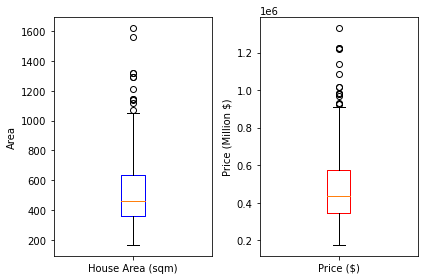

In [32]:
#Checking for outliers

plt.figure()
plt.subplot(1,2,1)
plt.boxplot(data['House Area (sqm)'], boxprops=dict(color='blue'))
plt.xticks([1], ['House Area (sqm)'])
plt.ylabel('Area')

plt.subplot(1,2,2)
plt.boxplot(data['Price ($)'], boxprops=dict(color='red'))
plt.xticks([1], ['Price ($)'])
plt.ylabel('Price (Million $)')

plt.tight_layout()
plt.show()

Since there was not a lot of outliers I decided to remove outliers

In [33]:
#Removing outliers
IQR = data['House Area (sqm)'].quantile(0.75)-data['House Area (sqm)'].quantile(0.25)
Q3 = data['House Area (sqm)'].quantile(0.75)
data = data[data['House Area (sqm)'] < Q3+1.5*IQR]

IQR = data['Price ($)'].quantile(0.75)-data['Price ($)'].quantile(0.25)
Q3 = data['Price ($)'].quantile(0.75)
data = data[data['Price ($)'] < Q3+1.5*IQR]

In [34]:
#Data after removing outliers
print('Data shape:',data.shape, '\nData size:',data.size)

Data shape: (514, 8) 
Data size: 4112


Then I checked for null values and drop any duplicate rows

In [35]:
#Checking for missing values
print(data.isna().sum().sort_values())

House ID             0
City                 0
House Area (sqm)     0
No. of Bedrooms      0
No. of Toilets       0
Stories              0
Renovation Status    0
Price ($)            0
dtype: int64


In [36]:
#Drop duplicates (if any)
data = data.drop_duplicates()

# Data Processing

I one hot encoded the categorical variables to make them numerical for the model to read

In [37]:
#Define target(y) and X
y = data['Price ($)']
X = data.drop(['House ID','Price ($)'], axis=1) 
#Remove House ID since it is just a unique identifier
#Remove target from X as well

#Making data readable
City = pd.get_dummies(X['City'], prefix='City')
X = X.drop(['City'], axis=1)
encoded_data = pd.concat([X, City], axis=1)
X = encoded_data

Renovation = pd.get_dummies(X['Renovation Status'], prefix='Renovation')
X = X.drop(['Renovation Status'], axis=1)
encoded_data = pd.concat([X,Renovation], axis=1)
X = encoded_data

This graph uses information gain to determine the importance of the feature. It calculates the reduction in entropy from the transformation of a dataset. Entrophy is a measure of how uncertain or mixed up the target variable's values are. A high entropy means the target variable is more uncertain, while a low entropy means it is more predictable.

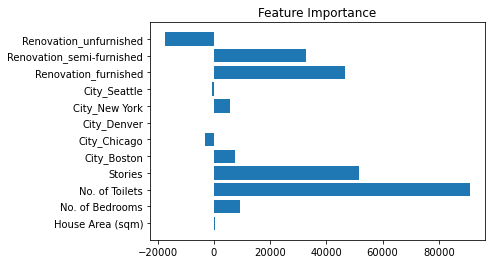

In [38]:
from sklearn.linear_model import Lasso

# Instantiate a lasso regression model
lasso = Lasso(alpha=0.3,max_iter=10000)

# Fit the model to the data
lasso.fit(X,y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
plt.barh(X.columns, lasso_coef)
plt.title("Feature Importance")
plt.show()

This is a heatmap which i plotted the correlation matrix of the features to see the correlation between each variables. By doing so, I can determine which features are greatly correlation to one another and remove that variable, removing noise and preventing multicollinearity.

Multicollinearity causes problems to the model as it becomes challenging to interpret the impact of the individual features and other huge problems

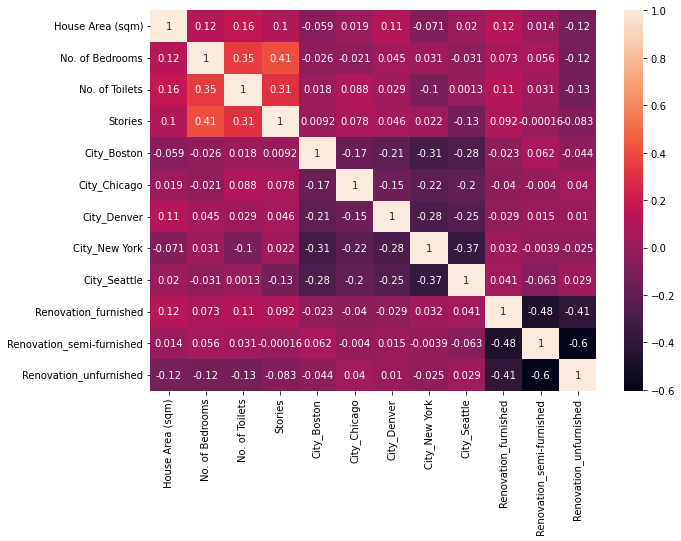

In [39]:
cor = X.corr()
plt.figure(figsize = (10,7))
sns.heatmap(cor,annot=True)
plt.show()

Based on this correlation heatmap, I can see that Renovation_semi-furnished and Renovation_unfurnished have a moderately strong negative linear relationship of -0.6

# Feature Selection

__CITY__

Based on this article, affordability of houses varies by states, with the average US house having a price of about 332,911 USD.
The most expensive state being Hawaii with a median house price of 834,583 USD.
The least expensive state being West Virginia with a median house price of 146,578 USD. Thus I decided to keep City column.

https://www.fool.com/the-ascent/research/average-house-price-state/ 

__House Area (sqm)__

"The typical American family can expect to pay about $169 per square foot of house, but depending on where they live, that number can grow significantly." This means that as the house area increases the price of the house increases as well. Thus I decided to keep House Area (sqm) column.

https://homebay.com/price-per-square-foot-2022/

__No. of Bedrooms__

"An extra bedroom will typically add 15 percent to the resale value of a house. However, that may not necessarily cover the initial cost of a room addition." Naturally if house area has a positive linear relationship with house pricing, having an extra room will in turn increase the house area thus increasing the house. Thus, I decided to keep No. of Bedrooms.

https://www.briggsfreeman.com/blog/posts/2021/09/20/will-adding-a-bedroom-or-office-to-your-home-really-increase-its-value/

__No. of Toilets__

"Adding a new toilet or updating an existing one can increase the value of your home by .5-1% of your home’s value. In general, it is around 66% of the cost of the toilet itself." This also goes with the house area logical where increasing the area of the house will increase the price, even though with a toilet, it increases the house value by such a small amoutn since the area being added to the house is so small. Thus I decided to keep No. of Toilets column.

https://www.badeloftusa.com/buying-guides/how-much-value-does-a-bathroom-add/

__Stories__

On average, you can expect to pay 30% more when building a two story home than a one story home of comparative size. Since price of house increases with house area, naturally, the price of house will increase when there is more than one story, since another floor will count towards the overall square footage. Thus I decided to keep Stories column.

https://www.gjgardner.com/planning-your-build/one-story-vs-two-story-houses/

__Renovation Status__

"It takes into account the total cost of your updates and the current value of the home. This is one of the most important terms to understand when it comes to qualifying for renovation loans.
Like we mentioned, in essence, you can estimate your ARV with this formula:

Estimated Current Home Value + (70% x Cost of Renovations) = ARV" 

Where ARV stands for After Renovation Value thus renovating your house will lead to a more expensive house. Thus, I decided to keep Renovation Status column

https://www.renofi.com/learn/after-renovation-value-calculator/

# Selecting Columns

In [40]:
#Selecting Columns
X_df = X.drop(['Renovation_unfurnished'], axis=1)
X = X_df.values

I decided to drop the Renovation_unfurnished columns since Renovation_semi-furnished and Renovation_unfurnished have a moderately strong negative linear relationship with a correlation coefficient of -0.6. The reason I dropped unfurnished instead of semi-furnished is due to the importances graph showing that semi-furnished was more important than unfurnished.

# Train-test split

I used the train_test_split code to split my code into two parts. 80% of the data will go into train where it will be used to train my model and 20% will go into test where it will be used to test my trained model. I also stratified it so that the distribution between the train and the test will be about the same.

In [41]:
#Split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Deciding what model to use

I decided to use Linear Regression particularly ElasticNet since it uses Lasso and Ridge to get the best of both worlds. This is to counter the fact the Linear Regression tends to overfit thus adding regularization will help the model to not overfit, by 'punishing' everytime it overfits.

I decided to use Random Forest which is made of a bunch of trees.These trees are made independently with a random set of data. Each tree is also looks at a different feature which is also randomly selected. Tree or decision tree is a model that uses a bunch of splits under different feature and finds the best routes to take to predict the outcome based on the data given. Random Forest is also robust to overfitting and both Random Forest and Gradient Boosting looks at feature importance which is good in a real world context such as predicting house prices.

I decided to use Gradient Boosting since I removed the outliers thus removing the disadvantage of Gradient Boosting being sensitive to outliers. I like Gradient Boosting due to the fact that it self-improves, by using a simple model like Tree to try and improve the previous prediction thus making it precise.

# Model building

I used Pipeline so that I can chain together a sequence of steps such as scaling my data in putting it into my model. I then used KFold for cross-validation where the dataset is divided into K subsets or folds of approximately equal size and the model is trained n times, each time using n-1 folds as the training set and the remaining fold as the validation set.

# Hyperparameters

I did not have to manually check which hyperparameters is the best for my model as I can use GridSearchCV or RandomizedSearchCV to find the best hyperparameters. By using RandomizedSearchCV, it will choose a random set of hyperparameters to use and find out which set is the best. This saves alot of time however it might not get the best set in the first try. GridSearchCV one the other hand will go through all possible iterations which is very accurate but takes up alot of time.

I also imported sp_randFloat and sp_randInt so that I can easily input all possible ranges of the hyperparameter.

# Dummy Baseline

Before I use make the models, I will be finding the dummy baseline for the dataset.

In [42]:
from sklearn.dummy import DummyRegressor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_scaled, y_train)
dpred = dummy_regr.predict(X_test_scaled)

dmse = mean_squared_error(y_test, dpred)
dmae = mean_absolute_error(y_test, dpred)
dmape = (mean_absolute_error(y_test,dpred) / np.mean(y_test)) * 100
dr2 = dummy_regr.score(X_test_scaled, y_test)
drmse = np.sqrt(dmse)
devs = explained_variance_score(y_test, dpred)
print(f'Dummy Mean Squared Error: {dmse:.5f}\nDummy Mean Absolute Error: {dmae:.5f}\nDummy Mean Absolute Percentage Error: {dmape:.5f}\nDummy Root-Mean Square Deviation: {drmse}\nDummy Explained Variance Score: {devs:.5f}\nDummy R-Squared: {dr2:.5f}')

Dummy Mean Squared Error: 27609135307.57379
Dummy Mean Absolute Error: 129947.48211
Dummy Mean Absolute Percentage Error: 27.60792
Dummy Root-Mean Square Deviation: 166159.96902856533
Dummy Explained Variance Score: 0.00000
Dummy R-Squared: -0.01551


# Elastic Net Model

For Elastic Net Model, I used GridSearchCV since it only has 2 hyperparameters. This ensures that I can get the best hyperparameters since it goes through every possible iteration.

In [55]:
# Scale the input features (X)

steps = [('scaler', StandardScaler()),('enet',ElasticNet(random_state=12,max_iter=5000))]
pipeline = Pipeline(steps)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for the grid search
param_grid = {
    'enet__alpha': np.arange(0.1,1,0.01), 
    'enet__l1_ratio': np.arange(0.1,1,0.01) 
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf)
grid_search.fit(X_train, y_train)

enet_predictions = grid_search.predict(X_test)

# Get the best hyperparameters and model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Model Score:", test_score)

enet_mse = mean_squared_error(y_test, enet_predictions)
enet_mae = mean_absolute_error(y_test, enet_predictions)
enet_mape = (mean_absolute_error(y_test, enet_predictions) / np.mean(y_test)) * 100
enet_r2 =  grid_search.score(X_test, y_test)
enet_rmse = np.sqrt(enet_mse)
enet_evs = explained_variance_score(y_test, enet_predictions)
print(f'Mean Squared Error: {enet_mse:.5f}\nMean Absolute Error: {enet_mae:.5f}\nMean Absolute Percentage Error: {enet_mape:.5f}\nRoot-Mean Square Deviation: {enet_rmse}\nExplained Variance Score: {enet_evs:.5f}\nR-Squared: {enet_r2:.5f}')

Best Hyperparameters: {'enet__alpha': 0.9899999999999995, 'enet__l1_ratio': 0.9399999999999996}
Best Model Score: 0.46100805986945814
Mean Squared Error: 14653837104.05756
Mean Absolute Error: 90994.83157
Mean Absolute Percentage Error: 19.33226
Root-Mean Square Deviation: 121053.03426208514
Explained Variance Score: 0.46673
R-Squared: 0.46101


# Elastic Net Model Visualisation

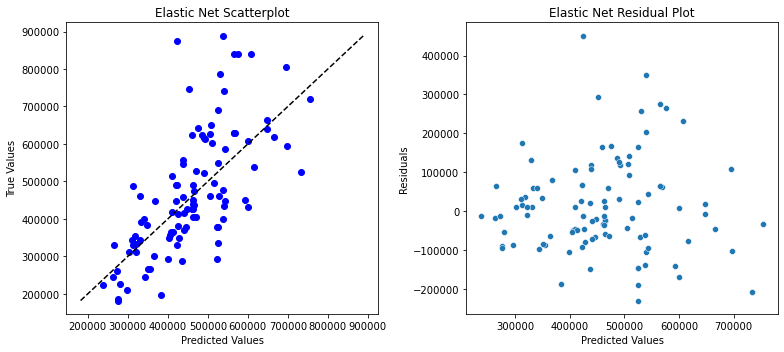

In [44]:
# Create scatter plot
residuals = y_test - enet_predictions
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)

plt.scatter(enet_predictions, y_test, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.title("Elastic Net Scatterplot")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

# Scatter plot of residuals against predicted values
plt.subplot(1,2,2)
sns.scatterplot(x=enet_predictions, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Elastic Net Residual Plot')

plt.tight_layout()
plt.show()

# Elastic Net Model Evaluation

In Regression, the accuracy of the model is calculated by Mean Squared Error, Mean Absolute Error, Explained Variance Score and R-Squared.

__Mean Squared Error__

Mean Squared Error(MSE) is calculated when you take the mean of the sum of squared errors, which is how far the predicted is from the actual value and square it to remove the negative. The larger the MSE, the more the data is spreaded out from the mean. This is evident from the scatter plot where my points are scatter pretty far away from the center which justifies my MSE score of 14653837104.05756 which is pretty bad. However Mean Squared Error is sensitive to outliers as a squared huge error could increase MSE by alot.

__Mean Absolute Error__

Mean Absolute Error(MAE) is calculated when you take the mean of the sum of absolute errors, which is the absolute difference of the predicted value from the actual value. MAE is similar to MSE but the difference is that it is less sensitive to outliers since instead of squaring the error, it just takes the absolute difference. This can be seen from my model's MAE of 90994.83157 which is much different than MSE which means there might be outliers or data with huge differences at play. Similarly, my MAE is quite bad as seen from the scatterplot.

__Mean Absolute Percentage Error__

Mean Absolute Percentage Error(MAPE) is a metric that defines the accuracy of a forecasting or predicting method. It is calculated by adding up all the absolute percent errors together and divide the sum by the number of errors.This means that for my model with a MAPE of 19.3%, my predictions have deviated 19.3% on average away from the true values.

__Root-Mean Square Deviation__

Root Mean Square Deviation(RMSE) is measures the average difference between a statistical model’s predicted values and the actual values. It is calculated by taking the square root of MSE. This means that my model with a RMSE of 166159.97 is not very good, but looking at the dataset, it is not not worse since the price is in the millions range so an average difference of 166159  is not the worse.

__Explained Variance Score__

Explained Variance Score(EVS) is calculated by comparing the variance of the predicted values to the variance of the actual values. It measures how well the model is able to capture variability in the target variable.EVS is similar to the R^2 score, with the notable difference that it does not account for systematic offsets in the prediction, which is when there is a consistent error in the prediction occuring, which follows a pattern. This could be due to a bunch of things like data skewness, model assumptions etc. and thus R2 is prefered over EVS. My model has an EVS of 0.46673 which is quite bad thus showing that it does not capture variability in the target variable well.

__R-Squared__

R-squared also known as coefficient of determination is a measure that shows how well the model fits to the observed data. It accounts for systematic offsets and bias in the prediction which is why it is prefered over EVS. My model's R2 is not very good with a R2 of 0.46101 which shows that my model does not fit that well to the observed data. This can also be seen from the residual plot which has alot of data points that is far from 0.

# Random Forest Model

In [45]:
# Scale the input features (X)
steps = [('scaler', StandardScaler()),('rf',RandomForestRegressor(random_state=12))]
pipeline = Pipeline(steps)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestRegressor(random_state=12)

# Define the parameter grid for the grid search
parameters = {
              'rf__n_estimators': sp_randInt(10,1000),
              'rf__max_depth': sp_randInt(4,10),
              'rf__min_samples_split': sp_randInt(2,10),
              'rf__min_samples_leaf': sp_randInt(2,100)
             }

# Perform grid search using cross-validation
Rf = RandomizedSearchCV(pipeline, param_distributions = parameters,
                               cv = kf, n_iter = 10)

Rf.fit(X_train, y_train)
predictions = Rf.predict(X_test)

# Get the best hyperparameters and model
best_model = Rf.best_estimator_

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)

print("Best Hyperparameters:", Rf.best_params_)
print("Best Model Score:", test_score)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = (mean_absolute_error(y_test, predictions) / np.mean(y_test)) * 100
r2 =  Rf.score(X_test, y_test)  
rmse = np.sqrt(mse)
evs = explained_variance_score(y_test, predictions)
print(f'Mean Squared Error: {mse:.5f}\nMean Absolute Error: {mae:.5f}\nMean Absolute Percentage Error: {mape:.5f}\nRoot-Mean Square Deviation: {rmse}\nExplained Variance Score: {evs:.5f}\nR-Squared: {r2:.5f}')

Best Hyperparameters: {'rf__max_depth': 5, 'rf__min_samples_leaf': 15, 'rf__min_samples_split': 9, 'rf__n_estimators': 432}
Best Model Score: 0.47223845578153023
Mean Squared Error: 14348510845.80272
Mean Absolute Error: 88384.04643
Mean Absolute Percentage Error: 18.77758
Root-Mean Square Deviation: 119785.26973631907
Explained Variance Score: 0.48097
R-Squared: 0.47224


Since I used RandomizeSearchCV, I ran the code 5 times to ensure that I got  good set of hyperparameters for my Random Forest Model. These are the results:

1) 
Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 359}
Best Model Score: 0.4757305430114267
Mean Squared Error: 14253569764.85136
Mean Absolute Error: 86136.76117
Explained Variance Score: 0.48711
R-Squared: 0.47573

2) 
Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 355}
Best Model Score: 0.4758977158749078
Mean Squared Error: 14249024754.56961
Mean Absolute Error: 86136.39373
Explained Variance Score: 0.48727
R-Squared: 0.47590

3) 
Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 2, 'n_estimators': 527}
Best Model Score: 0.47229715784390647
Mean Squared Error: 14346914884.16454
Mean Absolute Error: 88269.86260
Explained Variance Score: 0.48125
R-Squared: 0.47230

4) 
Best Hyperparameters: {'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 3, 'n_estimators': 696}
Best Model Score: 0.4713911672466575
Mean Squared Error: 14371546492.99097
Mean Absolute Error: 88328.41661
Explained Variance Score: 0.48045
R-Squared: 0.47139

5) 
Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 485}
Best Model Score: 0.4763911338619946
Mean Squared Error: 14235609958.78393
Mean Absolute Error: 86745.01172
Explained Variance Score: 0.48573
R-Squared: 0.47639

From the results, I can tell that number 5 is the best with a r-squared score of 0.476

# Final Random Forest Model

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor( 
    max_depth = 5,
    min_samples_leaf = 10,
    min_samples_split = 7,
    n_estimators = 485,
    random_state=12
)
rf.fit(X_train_scaled,y_train)
rf_predictions = rf.predict(X_test_scaled)

#Compute results
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mape = (mean_absolute_error(y_test, rf_predictions) / np.mean(y_test)) * 100
rf_rmse = np.sqrt(rf_mse)
rf_r2 =  rf.score(X_test_scaled, y_test)  
rf_evs = explained_variance_score(y_test, rf_predictions)
print(f'Mean Squared Error: {rf_mse:.5f}\nMean Absolute Error: {rf_mae:.5f}\nMean Absolute Percentage Error: {rf_mape:.5f}\nRoot-Mean Square Deviation: {rf_rmse}\nExplained Variance Score: {rf_evs:.5f}\nR-Squared: {rf_r2:.5f}')

Mean Squared Error: 14235609958.78393
Mean Absolute Error: 86745.01172
Mean Absolute Percentage Error: 18.42936
Root-Mean Square Deviation: 119313.07538901144
Explained Variance Score: 0.48573
R-Squared: 0.47639


# Random Forest Model Visualisation

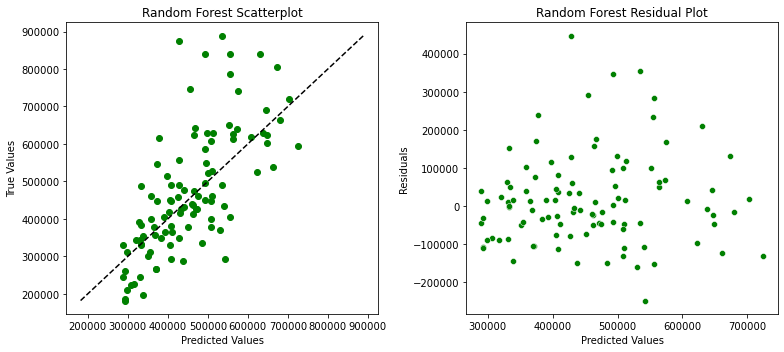

In [47]:
# Create scatter plot
residuals = y_test - rf_predictions
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)

plt.scatter(rf_predictions, y_test, color="green")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.title("Random Forest Scatterplot")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

# Scatter plot of residuals against predicted values
plt.subplot(1,2,2)
sns.scatterplot(x=rf_predictions, y=residuals,color='green')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Random Forest Residual Plot')

plt.tight_layout()
plt.show()

# Random Forest Evaluation

__Mean Squared Error__

My model's Mean Squared Error for Random Forest is also quite bad with a MSE of 14235609958.78393. As seen from the scatterplot, where it seems like 50% of the data points are close to the line. However MSE can be affected by outliers which aligns with the previous model's MSE since they are all using the same dataset. 

__Mean Absolute Error__

My model's Mean Absolute Error for Random Forest is quite bad with a MAE of 86745.01172 which is much smaller than MSE which means there are outliers or data points a huge difference from the predicted value at play.

__Mean Absolute Percentage Error__

My model has Mean Absolute Percentage Error of 18.4%, my predictions have deviated 18.4% on average away from the true values.

__Root-Mean Square Deviation__

My model with a RMSE of 119313.0754 is not very good, but looking at the dataset, it is not not worse since the price is in the millions range so an average difference of 119313 is not the worse.

__Explained Variance Score__

My model has an Explained Variance Score of 0.48573 which is quite bad thus showing that it does not capture variability in the target variable well. 

__R-Squared__

My model's R2 is not very good with a R2 of 0.47639 which shows that my model does not fit very well to the observed data. This can also be seen from the residual plot which has alot of data points that is far from 0.

# Gradient Boosting Model

In [48]:
steps = [('scaler', StandardScaler()),('gbr',GradientBoostingRegressor(random_state=12))]
pipeline = Pipeline(steps)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for the grid search
parameters = {
                  'gbr__learning_rate': sp_randFloat(),
                  'gbr__subsample'    : sp_randFloat(),
                  'gbr__n_estimators' : sp_randInt(100, 1000),
                  'gbr__max_depth'    : sp_randInt(4, 10),
                 }

# Perform grid search using cross-validation
gbr = RandomizedSearchCV(pipeline, param_distributions= parameters, cv=kf, n_iter = 10)
gbr.fit(X_train, y_train)

predictions = gbr.predict(X_test)

# Get the best hyperparameters and model
best_model = gbr.best_estimator_

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)

print("Best Hyperparameters:", gbr.best_params_)
print("Best Model Score:", test_score)

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = (mean_absolute_error(y_test, predictions) / np.mean(y_test)) * 100
rmse = np.sqrt(mse)
r2 =  gbr.score(X_test, y_test)  # Use best_estimator_ and y_test directly
evs = explained_variance_score(y_test, predictions)
print(f'Mean Squared Error: {mse:.5f}\nMean Absolute Error: {mae:.5f}\nMean Absolute Percentage Error: {mape:.5f}\nRoot-Mean Square Deviation: {rmse}\nExplained Variance Score: {evs:.5f}\nR-Squared: {r2:.5f}')

Best Hyperparameters: {'gbr__learning_rate': 0.07652250054536935, 'gbr__max_depth': 5, 'gbr__n_estimators': 281, 'gbr__subsample': 0.9418391445330022}
Best Model Score: 0.35436946841502304
Mean Squared Error: 17553072569.06464
Mean Absolute Error: 98623.45276
Mean Absolute Percentage Error: 20.95299
Root-Mean Square Deviation: 132488.00915201585
Explained Variance Score: 0.37754
R-Squared: 0.35437


Since I used Randomize Search, I rerun the code 5 times to make sure I get a good set of hyperparameters for my Gradient Boosting Model. These are the results:

1) 
Best Hyperparameters: {'gbr__learning_rate': 0.005139427230249738, 'gbr__max_depth': 8, 'gbr__n_estimators': 753, 'gbr__subsample': 0.8685409516829075}
Best Model Score: 0.4292237442791278
Mean Squared Error: 15517972814.53192
Mean Absolute Error: 93191.52418
Explained Variance Score: 0.44094
R-Squared: 0.42922

2) 
Best Hyperparameters: {'gbr__learning_rate': 0.2878526114157761, 'gbr__max_depth': 7, 'gbr__n_estimators': 139, 'gbr__subsample': 0.9206621835829678}
Best Model Score: 0.34972143718117166
Mean Squared Error: 17679440864.18039
Mean Absolute Error: 99788.42814
Explained Variance Score: 0.36182
R-Squared: 0.34972

3) 
Best Hyperparameters: {'gbr__learning_rate': 0.020753949962672325, 'gbr__max_depth': 4, 'gbr__n_estimators': 443, 'gbr__subsample': 0.5946943418544971}
Best Model Score: 0.4901778353843774
Mean Squared Error: 13860784171.47748
Mean Absolute Error: 87766.14296
Explained Variance Score: 0.50155
R-Squared: 0.49018

4) 
Best Hyperparameters: {'gbr__learning_rate': 0.055863172755770574, 'gbr__max_depth': 6, 'gbr__n_estimators': 140, 'gbr__subsample': 0.8121842360504485}
Best Model Score: 0.4291322328937568
Mean Squared Error: 15520460779.25745
Mean Absolute Error: 93446.85421
Explained Variance Score: 0.44477
R-Squared: 0.42913

5) 
Best Hyperparameters: {'gbr__learning_rate': 0.0033683736496671335, 'gbr__max_depth': 9, 'gbr__n_estimators': 931, 'gbr__subsample': 0.04942921712284665}
Best Model Score: 0.4928653553214526
Mean Squared Error: 13815273572.31623
Mean Absolute Error: 84549.89454
Explained Variance Score: 0.50026
R-Squared: 0.49185

From those results, I can tell that number 5 is the best with an r-squared score of 0.493. I also can tell that Gradient Boosting requires precise hyperparameter tuning since the variation between results are large.

# Final Gradient Boosting Model (Best Model)

In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gbr = GradientBoostingRegressor( 
    learning_rate = 0.0033683736496671335,
    max_depth = 9,
    n_estimators = 931,
    subsample = 0.04942921712284665,
    random_state=12
)
gbr.fit(X_train_scaled,y_train)
gbr_predictions = gbr.predict(X_test_scaled)

#Compute results
gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_mae = mean_absolute_error(y_test, gbr_predictions)
gbr_mape = (mean_absolute_error(y_test,gbr_predictions)/np.mean(y_test))*100
gbr_rmse = np.sqrt(gbr_mse)
gbr_r2 =  gbr.score(X_test_scaled, y_test)  
gbr_evs = explained_variance_score(y_test, gbr_predictions)
print(f'Mean Squared Error: {gbr_mse:.5f}\nMean Absolute Error: {gbr_mae:.5f}\nMean Absolute Percentage Error: {gbr_mape:.5f}\nRoot-Mean Square Deviation: {gbr_rmse}\nExplained Variance Score: {gbr_evs:.5f}\nR-Squared: {gbr_r2:.5f}')

Mean Squared Error: 13815273572.31623
Mean Absolute Error: 84549.89454
Mean Absolute Percentage Error: 17.96300
Root-Mean Square Deviation: 117538.39190798992
Explained Variance Score: 0.50026
R-Squared: 0.49185


# Gradient Boosting Model Visualisation

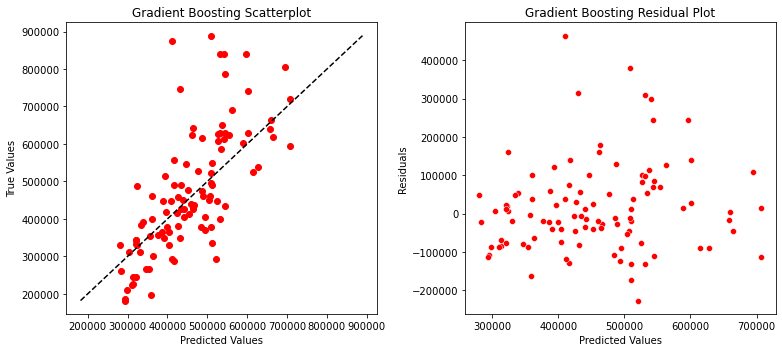

In [50]:
# Create scatter plot
residuals = y_test - gbr_predictions
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)

plt.scatter(gbr_predictions, y_test, color="red")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.title("Gradient Boosting Scatterplot")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

# Scatter plot of residuals against predicted values
plt.subplot(1,2,2)
sns.scatterplot(x=gbr_predictions, y=residuals,color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Gradient Boosting Residual Plot')

plt.tight_layout()
plt.show()

# Gradient Boosting Evaluation

__Mean Squared Error__

My model's Mean Squared Error for Gradient Boositng is also quite bad with a MSE of 13815273572.31623. As seen from the scatterplot, where it seems like 55% of the data points are close to the line. However MSE can be affected by outliers which aligns with the previous models' MSE since they are all using the same dataset. 

__Mean Absolute Error__

My model's Mean Absolute Error for Gradient Boosting is quite bad with a MAE of 84549.89454 which is much smaller than MSE which means there are outliers or data points a huge difference from the predicted value at play. This also aligns with the other models as they are all using the same dataset.

__Mean Absolute Percentage Error__

My model has Mean Absolute Percentage Error of 18.0%, my predictions have deviated 18.0% on average away from the true values.

__Root-Mean Square Deviation__

My model with a RMSE of 117538.39 is not very good, but looking at the dataset, it is not not worse since the price is in the millions range so an average difference of 117538 is not the worse.

__Explained Variance Score__

My model has an Explained Variance Score of 0.50026 which slightly better than the rest of the models but still not very good thus showing that it does not capture variability in the target variable well. 

__R-Squared__

My model's R2 is not very good with a R2 of 0.49185 which shows that my model does not fit very well to the observed data. This can also be seen from the residual plot which has alot of data points that is far from 0.

# Models' Feature Importance

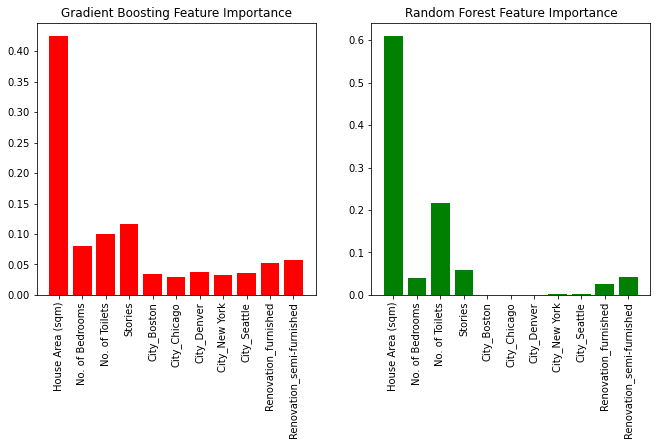

In [51]:
gbr_importance = gbr.feature_importances_
# plot feature importance
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.bar(X_df.columns, gbr_importance,color='r')
plt.title("Gradient Boosting Feature Importance")
plt.xticks(rotation=90)

rf_importance = rf.feature_importances_
plt.subplot(1,2,2)
plt.bar(X_df.columns, rf_importance, color='g')
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=90)

plt.show()

As expected, the model thinks that House Area (sqm) is the most important feature. From looking at the previous feature importance model made by Lasso, I was quite puzzled to see that House Area(sqm) was not at all important but rather the number of toilets were, which did not line up with my research. Thus I am satisfied to see that the model thinks that House Area (sqm) is the most important feature.

It is also interesting to see the difference in models feature importance. In Gradient Boosting, I can see that it thinks City holds at least abit of importance which aligns with my research but in Random Forest, it feels that City does not hold little to none importance and for Random Forest, the importance in the number of toilets outweighs the importances of the number of bedrooms and stories but in Gradient Boosing, Stories outweighs both of them. Overall, it feels that Gradient Boosting's feature importance aligns with a research and understanding more.

# Overall Comparison

In [57]:
# Create data for the dataframe
overall_data = {
    'MSE': [enet_mse, rf_mse,gbr_mse, dmse],
    'MAE': [enet_mae, rf_mae, gbr_mae, dmae],
    'MAPE': [enet_mape, rf_mape, gbr_mape, dmape],
    'RMSE': [enet_rmse, rf_rmse, gbr_rmse, drmse],
    'EVS': [enet_evs, rf_evs, gbr_evs, devs],
    'R2': [enet_r2, rf_r2, gbr_r2, dr2]
}

# Create the dataframe with index
overall_df = pd.DataFrame(overall_data, index=['Elastic Net', 'Random Forest', 'Gradient Boosting','Dummy Baseline'])

# Display the dataframe
overall_df

,MSE,MAE,MAPE,RMSE,EVS,R2
Elastic Net,1.465384e+10,90994.831570,19.332255,121053.034262,0.466731,0.461008
Random Forest,1.423561e+10,86745.011724,18.429362,119313.075389,0.485734,0.476391
Gradient Boosting,1.381527e+10,84549.894541,17.963000,117538.391908,0.500260,0.491852
Dummy Baseline,2.760914e+10,129947.482106,27.607918,166159.969029,0.000000,-0.015509


From the table, I can tell that Gradient Boosting is the best model, having a lower MSE, MAE, MAPE and a higher EVS and R2 than the rest of the model.

__Error__

From the table, I can also see that the system makes alot of errors, having an average MAPE percentage of about 18.575% which is not bad since the average predictions deviates from the true values 18.575% of the time.

However looking at the RMSE, MSE and MAE i can tell that the mean error is very bad. My system have a mean MSE of 14234906878.386 , a mean MAE of 87429.913 and a mean RMSE of 119301.50 This could be due to outliers can also partly due to the target value having such a high such, being around the millions. Thus slight deviation could result in a higher error.

# System's Performance Against the Dummy Baseline

From the table, I can see that all my models outperform the dummy baseline. 

My system have a mean MSE of 14234906878.386 while the dummy baseline have a MSE of 27609135307.574

My system have a mean MAE of 87429.913 while the dummy baseline have a MAE of 129947.482

My system have a mean MAPE of 18.575% while the dummy baseline have a MAPE of 27.608%

My system have a mean RMSE of 119301.50 while the dummy baseline have a RMSE of 166159.97 

My system have a mean EVS of 0.484 while the dummy baseline have a EVS of 0.0

My system have a mean R2 of 0.476 while the dummy baseline have a R2 of -0.0155 which could mean the dummy regressor is overfitting or have some other issue